In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from copy import deepcopy

In [2]:
class Diffusion:
    def __init__(self, T=1000, device="cuda"):
        self.device = device
        self.T = T
        self.betas = torch.linspace(1e-4, 0.02, T).to(device)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_ab = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_1m_ab = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_ab * x_start + sqrt_1m_ab * noise

    def sample(self, model, img_size, batch_size):
        model.eval()
        x = torch.randn((batch_size, 3, img_size, img_size)).to(self.device)
        for t in reversed(range(self.T)):
            t_batch = torch.full((batch_size,), t, device=self.device, dtype=torch.long)
            predicted_noise = model(x, t_batch)
            beta = self.betas[t]
            alpha = self.alphas[t]
            alpha_bar = self.alpha_bars[t]
            noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
            coef1 = 1 / alpha.sqrt()
            coef2 = (1 - alpha) / (1 - alpha_bar).sqrt()
            x = coef1 * (x - coef2 * predicted_noise) + beta.sqrt() * noise
        return x

In [2]:
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.GroupNorm(8, out_c),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.GroupNorm(8, out_c),
        )
        self.act = nn.SiLU()
        self.residual = nn.Conv2d(in_c, out_c, 1) if in_c != out_c else nn.Identity()

    def forward(self, x):
        return self.act(self.block(x) + self.residual(x))

def get_timestep_embedding(timesteps, dim):
    half_dim = dim // 2
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * (-torch.log(torch.tensor(10000.0)) / (half_dim - 1))).to(timesteps.device)
    emb = timesteps[:, None].float() * emb[None, :]
    return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

class SelfAttention(nn.Module):
    def __init__(self, channels, num_heads=2):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.attn = nn.MultiheadAttention(channels, num_heads=num_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        x_ = self.norm(x)
        x_ = x_.reshape(B, C, H * W).permute(0, 2, 1)
        attn_out, _ = self.attn(x_, x_, x_)
        attn_out = attn_out.permute(0, 2, 1).reshape(B, C, H, W)
        return x + attn_out

class SkipAttention(nn.Module):
    def __init__(self, channels, num_heads=2):
        super().__init__()
        self.norm_q = nn.GroupNorm(8, channels)
        self.norm_kv = nn.GroupNorm(8, channels)
        self.attn = nn.MultiheadAttention(channels, num_heads=num_heads, batch_first=True)

    def forward(self, decoder_feat, encoder_feat):
        B, C, H, W = decoder_feat.shape
        q = self.norm_q(decoder_feat).reshape(B, C, H * W).permute(0, 2, 1)
        kv = self.norm_kv(encoder_feat).reshape(B, C, H * W).permute(0, 2, 1)
        attn_out, _ = self.attn(q, kv, kv)
        attn_out = attn_out.permute(0, 2, 1).reshape(B, C, H, W)
        return decoder_feat + attn_out

class AttentionUNet(nn.Module):
    def __init__(self, time_emb_dim=256):
        super().__init__()

        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.time_proj1 = nn.Linear(time_emb_dim, 64)
        self.time_proj2 = nn.Linear(time_emb_dim, 128)
        self.time_proj3 = nn.Linear(time_emb_dim, 256)
        self.time_proj4 = nn.Linear(time_emb_dim, 512)
        self.time_proj_up3 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 128)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 64)

        # Encoder
        self.down1 = ResBlock(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ResBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = ResBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = ResBlock(256, 512)
        self.attn = SelfAttention(512)

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.skip_attn3 = SkipAttention(256)
        self.dec3 = ResBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.skip_attn2 = SkipAttention(128)
        self.dec2 = ResBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ResBlock(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, 256)
        t_emb = self.time_mlp(t_emb)

        x1 = self.down1(x) + self.time_proj1(t_emb).unsqueeze(-1).unsqueeze(-1)
        x2 = self.down2(self.pool1(x1)) + self.time_proj2(t_emb).unsqueeze(-1).unsqueeze(-1)
        x3 = self.down3(self.pool2(x2)) + self.time_proj3(t_emb).unsqueeze(-1).unsqueeze(-1)

        x_bottleneck = self.bottleneck(self.pool3(x3)) + self.time_proj4(t_emb).unsqueeze(-1).unsqueeze(-1)
        x_bottleneck = self.attn(x_bottleneck)

        x = self.up3(x_bottleneck)
        x3 = self.skip_attn3(x, x3)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3(x) + self.time_proj_up3(t_emb).unsqueeze(-1).unsqueeze(-1)

        x = self.up2(x)
        x2 = self.skip_attn2(x, x2)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x) + self.time_proj_up2(t_emb).unsqueeze(-1).unsqueeze(-1)

        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x) + self.time_proj_up1(t_emb).unsqueeze(-1).unsqueeze(-1)

        return self.final(x)


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3),
])

dataset = datasets.ImageFolder("dataset", transform=transform)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = AttentionUNet().to(device)
ema_model = deepcopy(model)
ema_decay = 0.999

learning_rate = 5e-5
EPOCHS = 200

diffusion = Diffusion(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

os.makedirs("checkpoints", exist_ok=True)

# ✅ EMA 更新函數
@torch.no_grad()
def update_ema(model, ema_model, decay):
    for param, ema_param in zip(model.parameters(), ema_model.parameters()):
        ema_param.data.mul_(decay).add_(param.data, alpha=1 - decay)

for epoch in range(EPOCHS):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, diffusion.T, (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_t = diffusion.q_sample(x, t, noise)
        predicted = model(x_t, t)
        loss = nn.MSELoss()(predicted, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_ema(model, ema_model, ema_decay) 

        pbar.set_postfix(loss=loss.item())

    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"checkpoints/unet_epoch{epoch+1}.pth")
        torch.save(ema_model.state_dict(), f"checkpoints/ema_unet_epoch{epoch+1}.pth")

    scheduler.step()


cuda


Epoch 181/200:  40%|████      | 567/1404 [01:11<01:46,  7.88it/s, loss=0.0113] 


KeyboardInterrupt: 

In [ ]:
# 繼續訓練
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AttentionUNet().to(device)
ema_model = deepcopy(model)
ema_decay = 0.999

start_epoch = 180
end_epoch = 200

model.load_state_dict(torch.load(f"checkpoints/unet_epoch{start_epoch}.pth"))
ema_model.load_state_dict(torch.load(f"checkpoints/ema_unet_epoch{start_epoch}.pth"))

ema_decay = 0.999
learning_rate = 5e-5

diffusion = Diffusion(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=end_epoch, eta_min=1e-6)

for _ in range(start_epoch):
    scheduler.step()

@torch.no_grad()
def update_ema(model, ema_model, decay):
    for param, ema_param in zip(model.parameters(), ema_model.parameters()):
        ema_param.data.mul_(decay).add_(param.data, alpha=1 - decay)

os.makedirs("checkpoints", exist_ok=True)

for epoch in range(start_epoch, end_epoch):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{end_epoch}")
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, diffusion.T, (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_t = diffusion.q_sample(x, t, noise)
        predicted = model(x_t, t)
        loss = torch.nn.functional.mse_loss(predicted, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_ema(model, ema_model, ema_decay)

        pbar.set_postfix(loss=loss.item())

    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"checkpoints/unet_epoch{epoch+1}.pth")
        torch.save(ema_model.state_dict(), f"checkpoints/ema_unet_epoch{epoch+1}.pth")

    scheduler.step()


C:\Users\sandy\AppData\Local\Temp\ipykernel_24612\2611602177.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"checkpoints/unet_epoch{st

In [3]:
class Diffusion_DDIM:
    def __init__(self, T=1000, device="cuda"):
        self.device = device
        self.T = T
        self.betas = torch.linspace(1e-4, 0.02, T).to(device)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)


    def sample(self, model, img_size, batch_size, num_steps=50):
        model.eval()
        step_size = self.T // num_steps
        x = torch.randn((batch_size, 3, img_size, img_size)).to(self.device)

        for t in reversed(range(0, self.T, step_size)):
            t_batch = torch.full((batch_size,), t, device=self.device, dtype=torch.long)
            with torch.no_grad():
                predicted_noise = model(x, t_batch)

            alpha_bar = self.alpha_bars[t]
            alpha_bar_prev = self.alpha_bars[t - step_size] if t - step_size >= 0 else torch.tensor(1.0).to(self.device)

            x0_pred = (x - (1 - alpha_bar).sqrt() * predicted_noise) / alpha_bar.sqrt()
            x0_pred = torch.clamp(x0_pred, -1., 1.)

            sigma = 0  # DDIM: deterministic (no noise)
            dir_xt = ((1 - alpha_bar_prev).sqrt()) * predicted_noise
            x = alpha_bar_prev.sqrt() * x0_pred + dir_xt + sigma * torch.randn_like(x)

        return x


Generating from epoch 10


C:\Users\sandy\AppData\Local\Temp\ipykernel_24612\3536434647.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_gen.load_state_dict(torch.load(f"checkpoints/unet_epo

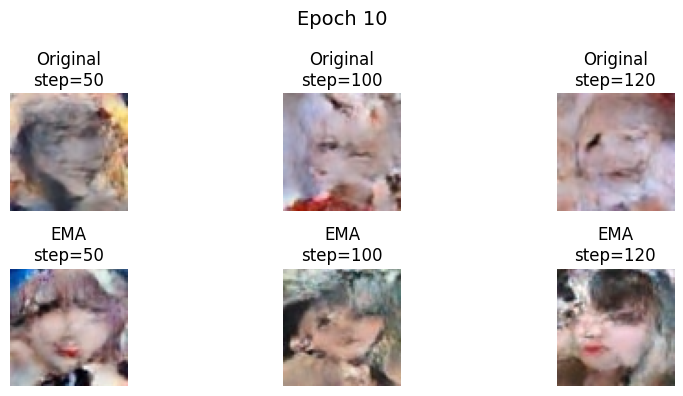

Generating from epoch 20


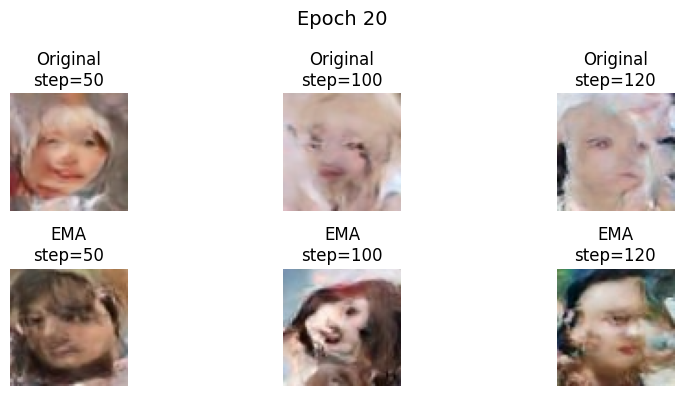

Generating from epoch 30


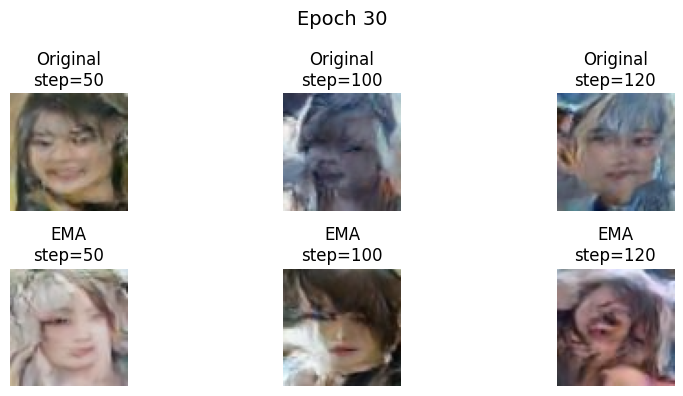

Generating from epoch 40


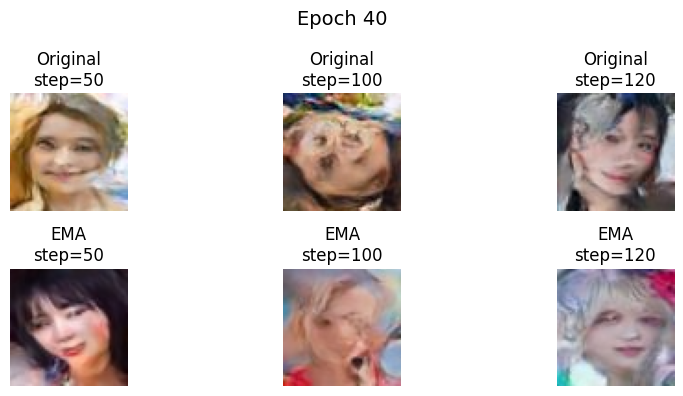

Generating from epoch 50


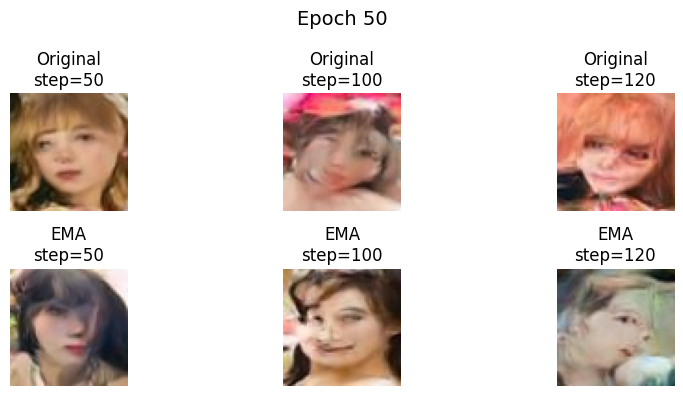

Generating from epoch 60


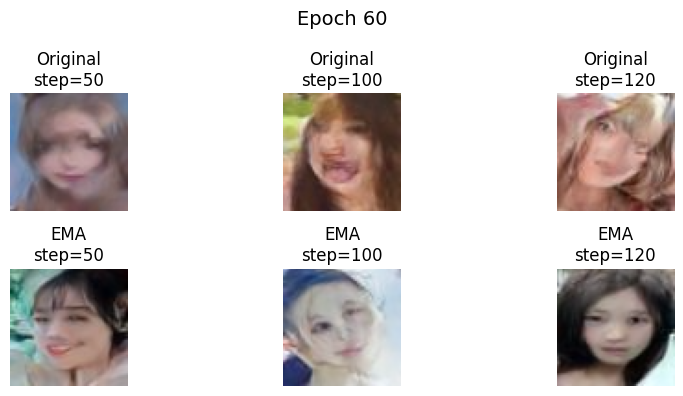

Generating from epoch 70


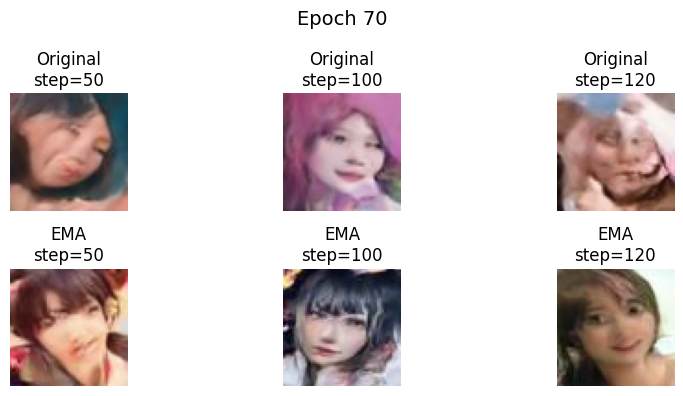

Generating from epoch 80


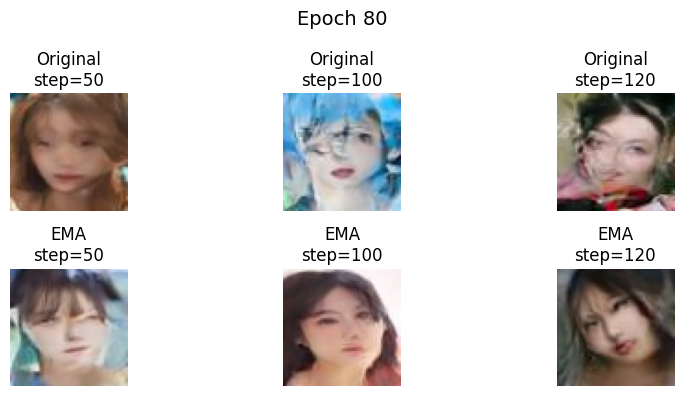

Generating from epoch 90


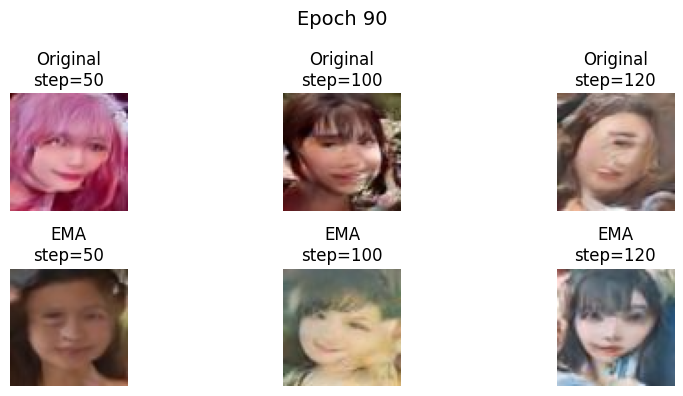

Generating from epoch 100


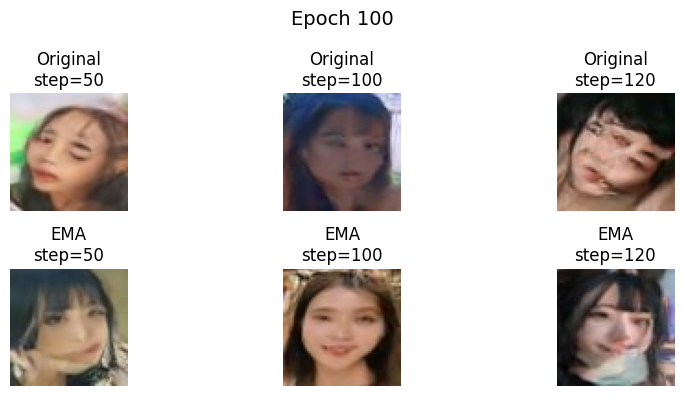

Generating from epoch 110


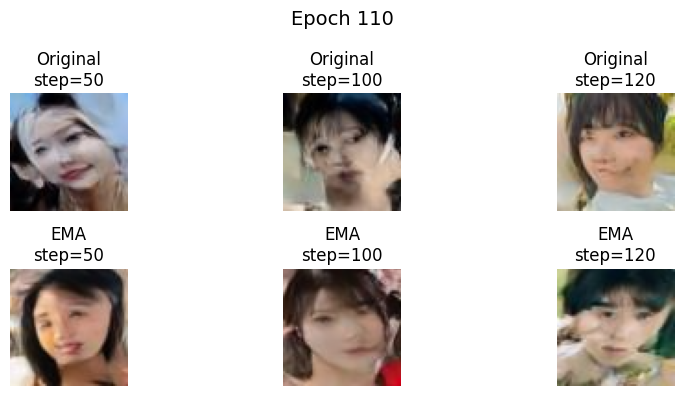

Generating from epoch 120


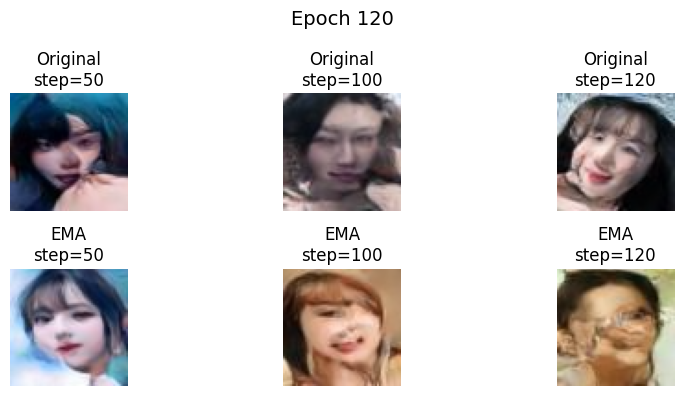

Generating from epoch 130


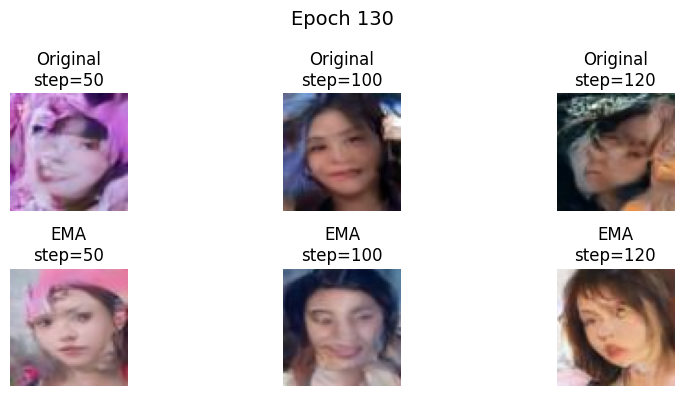

Generating from epoch 140


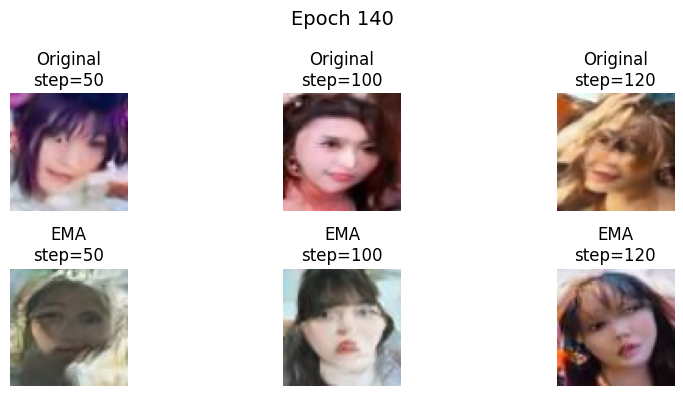

Generating from epoch 150


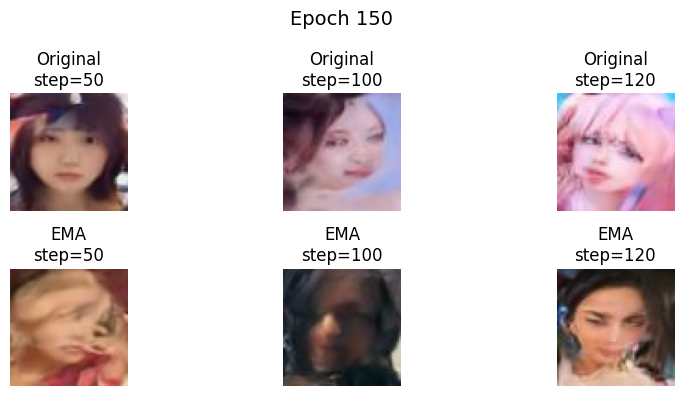

Generating from epoch 160


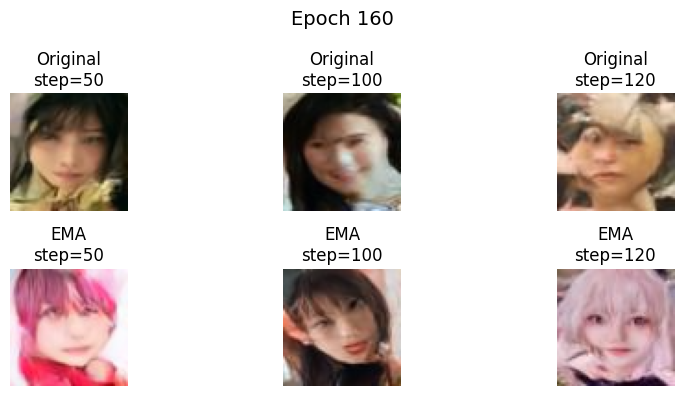

Generating from epoch 170


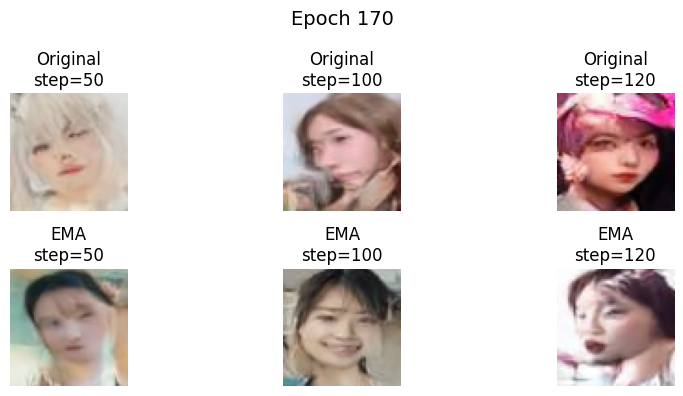

Generating from epoch 180


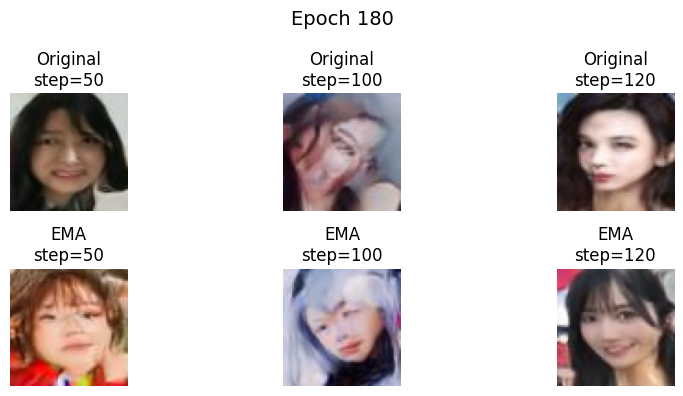

Generating from epoch 190


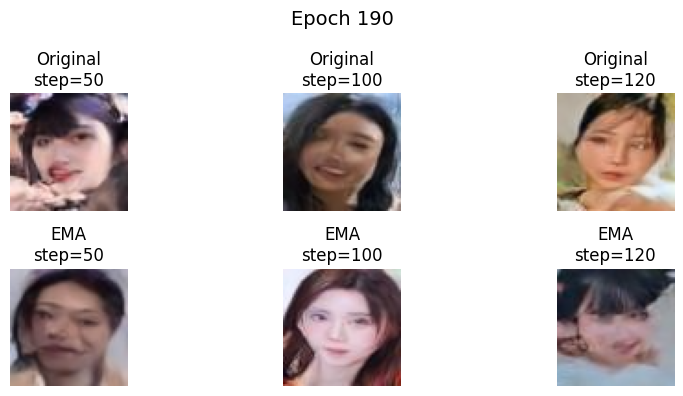

Generating from epoch 200


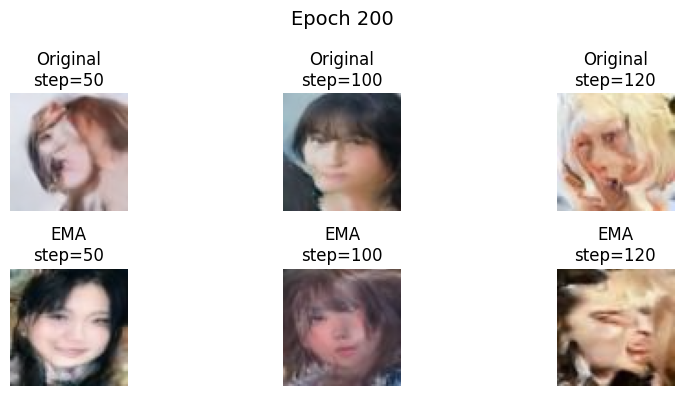

In [16]:
# 兩個模型 step 50 和 100 各生成一張

import matplotlib.pyplot as plt

model_gen = AttentionUNet().to(device)
diffusion = Diffusion_DDIM(device=device)

EPOCHS = 200

for epoch in range(EPOCHS):
    if (epoch + 1) % 10 != 0:
        continue

    epoch_id = epoch + 1
    print(f"Generating from epoch {epoch_id}")

    # === 載入原始模型 & EMA 模型 ===
    model_gen.load_state_dict(torch.load(f"checkpoints/unet_epoch{epoch_id}.pth"))
    model_gen.eval()

    ema_model = AttentionUNet().to(device)
    ema_model.load_state_dict(torch.load(f"checkpoints/ema_unet_epoch{epoch_id}.pth"))
    ema_model.eval()
    
    fig, axs = plt.subplots(2, 3, figsize=(9, 4))

    model_types = [("Original", model_gen), ("EMA", ema_model)]
    step_sizes = [50, 100, 120]

    for row, (model_name, model) in enumerate(model_types):
        for col, steps in enumerate(step_sizes):
            with torch.no_grad():
                sample = diffusion.sample(model, img_size=64, batch_size=1, num_steps=steps)[0]
                sample = sample * 0.5 + 0.5
                sample = sample.clamp(0, 1)

            ax = axs[row][col]
            ax.imshow(sample.permute(1, 2, 0).cpu().numpy())
            ax.axis("off")
            ax.set_title(f"{model_name}\nstep={steps}")

            del sample

    plt.suptitle(f"Epoch {epoch_id}", fontsize=14)
    plt.tight_layout()
    plt.show()
    # ✅ Optional: 強制清理顯卡記憶體
    # torch.cuda.empty_cache()
